<a href="https://colab.research.google.com/github/nidharap/Notebooks/blob/master/Attentions_in_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install the transformers library from Hugging face

In [43]:
!pip install transformers

In [44]:
# Basic imports
import torch
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
from transformers import BertConfig, BertModel, BertTokenizer
import seaborn as sns; sns.set()

% matplotlib inline
np.random.seed(0);

In [45]:
# Basic constants
model_name = "bert-base-uncased"
TOTAL_NO_LAYERS = 12
TOTAL_NO_ATTEN_HEADS = 12
CMAP = sns.light_palette("blue")


## Let's initialize the model with the right config and also setup the tokenizer for the particular model

*Notice the output_attentions=True passed to the config*

In [46]:
# output_attentions=True tells the api to return the attention weights for all layers as part of the output
config = BertConfig.from_pretrained(model_name, output_attentions=True)
bert_model = BertModel.from_pretrained(model_name, config=config)

#put the model in eval mode
#we just need to a fwd pass here
bert_model.eval()

#get tokenizer
tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=True)

## Let's tokenize the input sentence

In [47]:
# sent = "My sister has a dog and she loves him. He is cute."
sent = "The animal didn't cross the street because it was too tired"
#Add CLS and SEP Tokens considering it as one sentence
sent = "[CLS] " + sent + " [SEP]"
sent

"[CLS] The animal didn't cross the street because it was too tired [SEP]"

In [48]:
#apply tokenizer and get ids
tokenized_text = tokenizer.tokenize(sent)
tokenized_text_ids = tokenizer.convert_tokens_to_ids(tokenized_text)
tokenizer.convert_ids_to_tokens(tokenized_text_ids)

['[CLS]',
 'the',
 'animal',
 'didn',
 "'",
 't',
 'cross',
 'the',
 'street',
 'because',
 'it',
 'was',
 'too',
 'tired',
 '[SEP]']

## Lets do a forward pass with the input (tokenized) sentence

In [49]:
#Convert to torch tensor
input = torch.tensor(tokenized_text_ids)

print("input.shape: ", input.shape) #torch.Size([15])
input = input.unsqueeze(dim=0) #add a dimension 
print("input.shape: ", input.shape) #torch.Size([15])

#Fwd pass - get output
output = bert_model(input) 
print("len(output): ", len(output)) 

input.shape:  torch.Size([15])
input.shape:  torch.Size([1, 15])
len(output):  3


## The output is a list of tuples. You can find the exact docs here [link text](https://huggingface.co/transformers/model_doc/bert.html#pytorch_transformers.BertModel)

The third element has the attention weights for 12 layers

In [50]:
print(len(output[2]))  #12 => number of layers

12


In [51]:
#Let's explore the first layer
print("output[2][0].shape: ", output[2][0].shape) #torch.Size([1, 12, 15, 15]) -> [batch_size, num_attn_heads, inp_seq_len, inp_seq_len]
output[2][0].squeeze(0)[0].shape #removing the batch_size dim and accesing the first attention head

output[2][0].shape:  torch.Size([1, 12, 15, 15])


torch.Size([15, 15])

In [52]:
def get_attentions(outputs, layer=0, attention_head=0, avg=False):
  '''
  get the particular output for a particular layer and attention head
  layer -> 0 to 11
  attention_head -> 0 to 11
  '''
  if avg:
    #avg over all attention heads in a layer
    return outputs[layer].squeeze(0).mean(dim=0)

  #return values for a particular attention head inside a specific layer
  return outputs[layer].squeeze(0)[attention_head]

In [53]:
# test result
get_attentions(output[2], layer=0).shape

torch.Size([15, 15])

In [54]:
def plt_attentions(mat, labs, fig_size=(10,10), annot=False, cmap = CMAP, title=None):
  '''
  plot the NxN matrix passed as a heat map
  
  mat: square matrix to visualize
  labs: labels for xticks and yticks (the tokens in our case)
  '''
  fig, ax = plt.subplots(figsize=fig_size) 
  # labels = tokenizer.convert_ids_to_tokens(input[0][0:non_zero_idx+1].numpy());
  # ax = sns.heatmap(output[2][0].squeeze(0)[0][0:non_zero_idx+1, 0:non_zero_idx+1].detach().numpy(), annot=True, yticklabels=labs,xticklabels=labs)
  ax = sns.heatmap(mat.detach().numpy(), annot=annot, yticklabels=labs,xticklabels=labs, cmap=cmap)
  ax.xaxis.set_ticks_position('top')
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
  if title:
    ax.set_title(title)

In [55]:
def plot_all_attentions(atts, layer=0, cmap = CMAP):
  '''
  function to plot all the attention matrices for a particular layer
  atts: all the attention weights returned by the library
  layer: layer number 
  '''
  fig = plt.figure(figsize=(20,20),facecolor='w', edgecolor='k')
  plt.tight_layout()
  fig.subplots_adjust(hspace=.2, wspace=0)

  #loop through all attention heads
  for i in range(0, TOTAL_NO_ATTEN_HEADS):
      ax = fig.add_subplot(6, 6, i+1)
      ax.set_title("L{}, A{}".format(layer, i))
      
      #get the matrix for particular layer and current attention head
      mat = get_attentions(atts, layer=layer, attention_head=i)

      #plot heatmap using sns
      res = sns.heatmap(mat.detach().numpy(),cmap=cmap, ax=ax, cbar=False, yticklabels=[],xticklabels=[])
      
      # make frame visible
      for _, spine in res.spines.items():
          spine.set_visible(True)


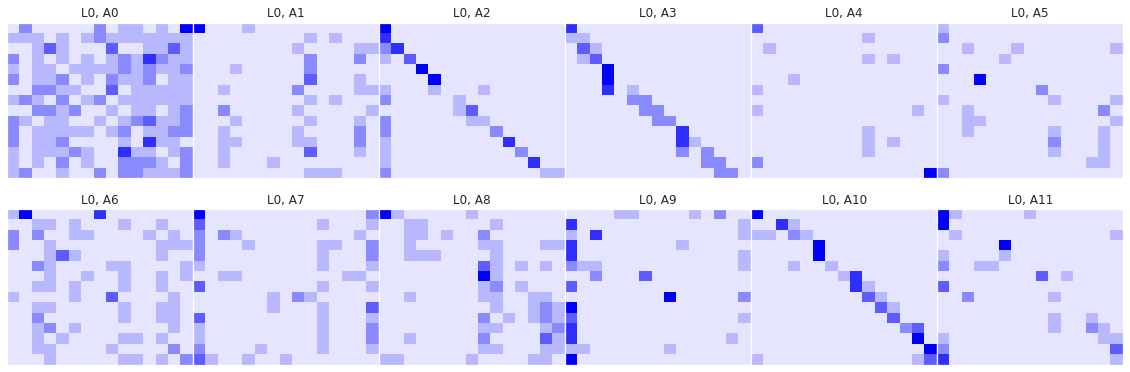

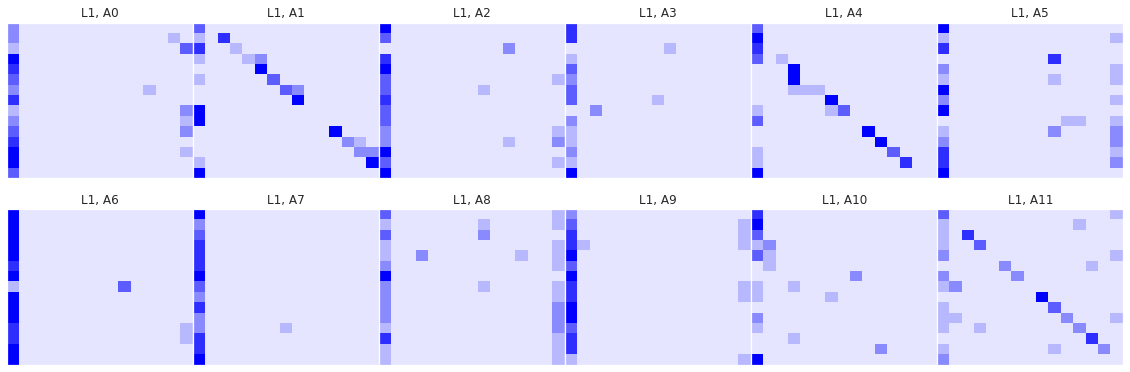

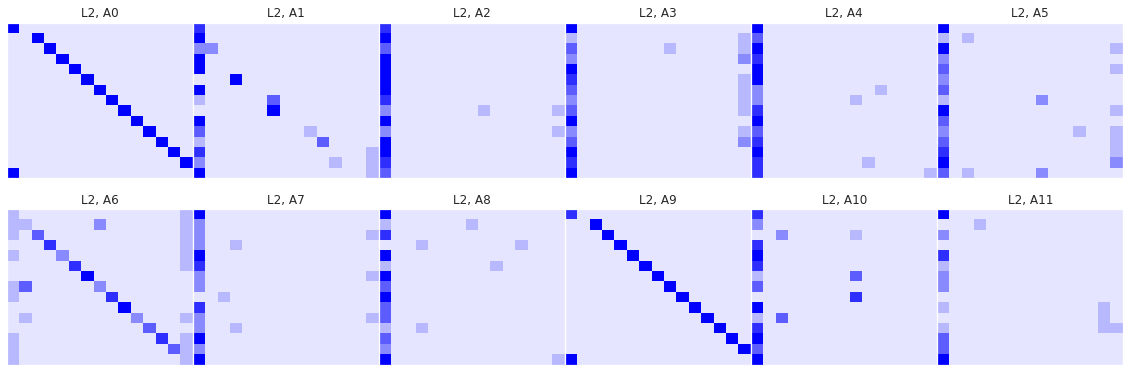

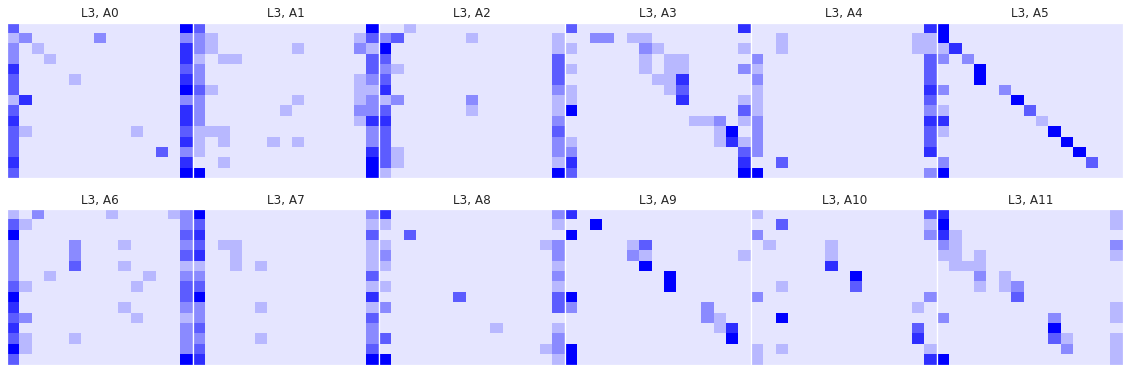

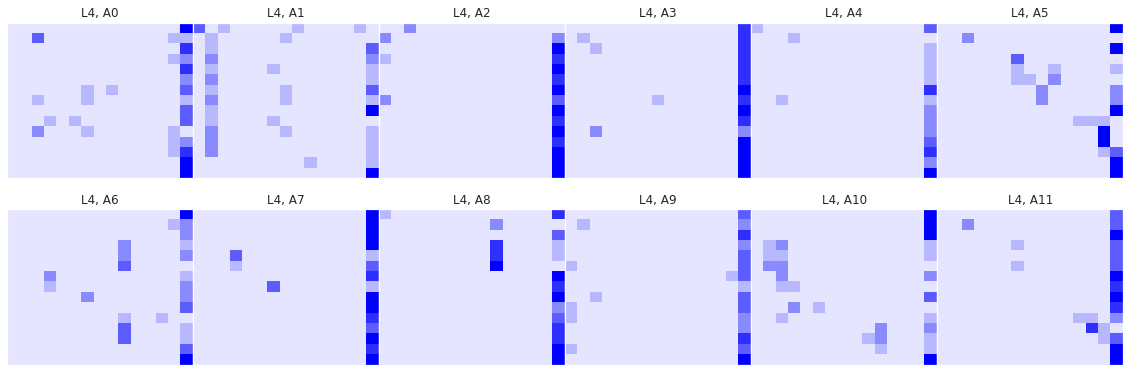

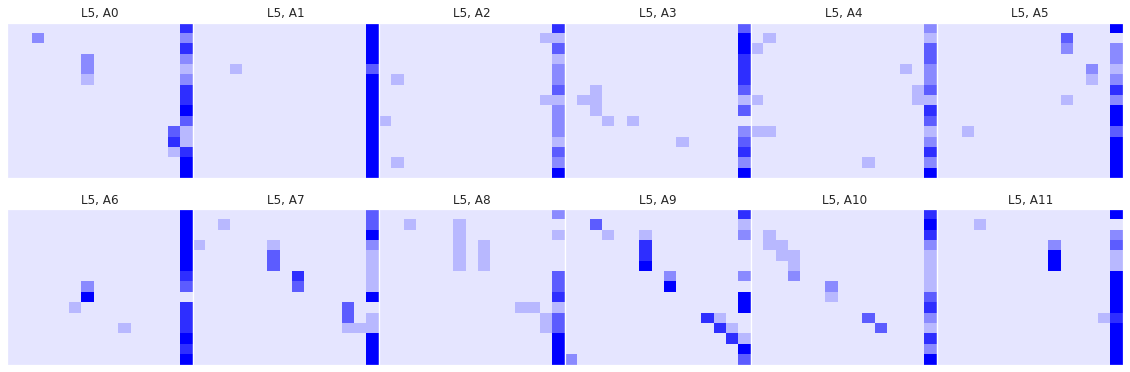

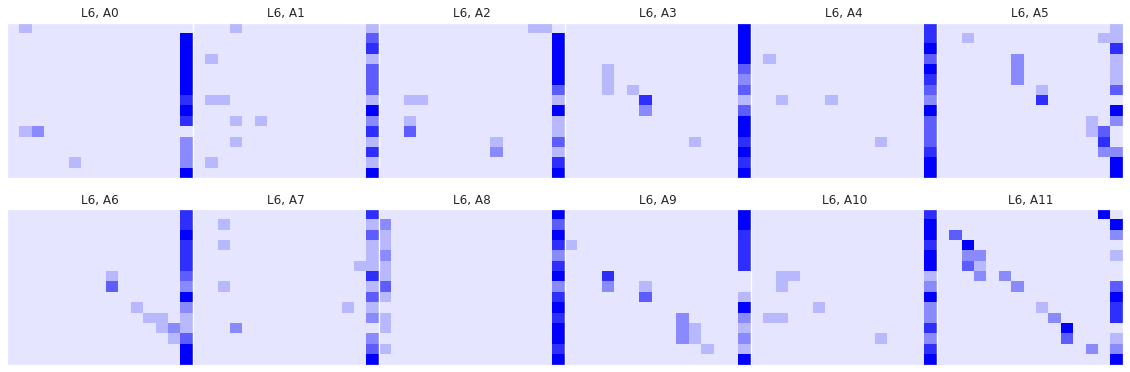

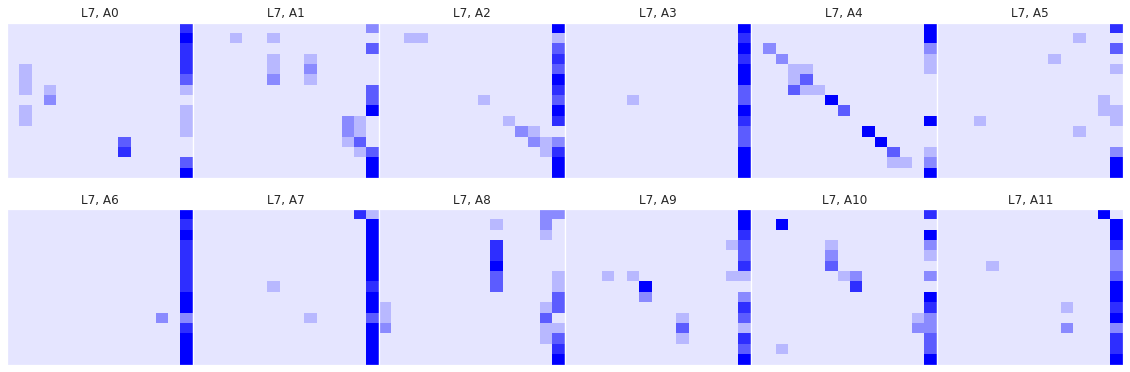

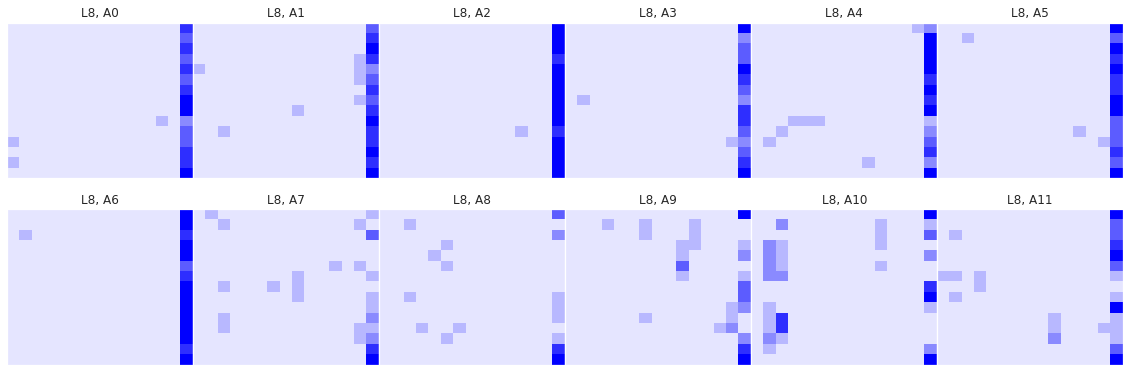

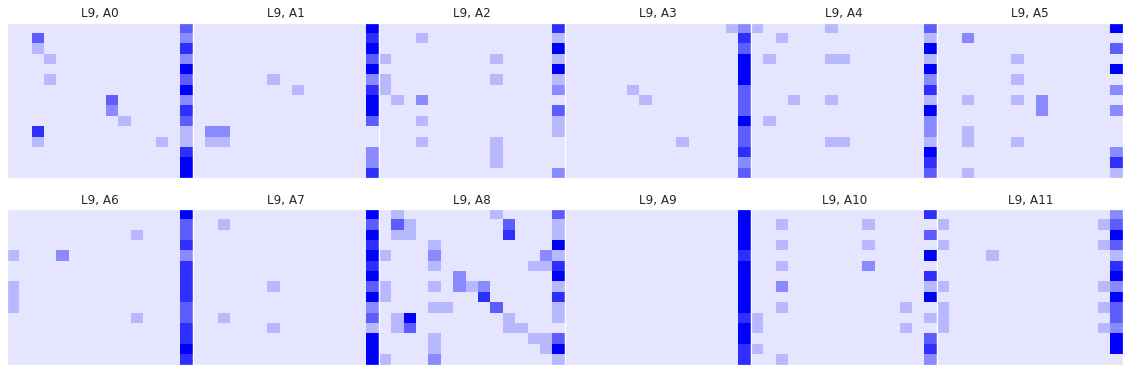

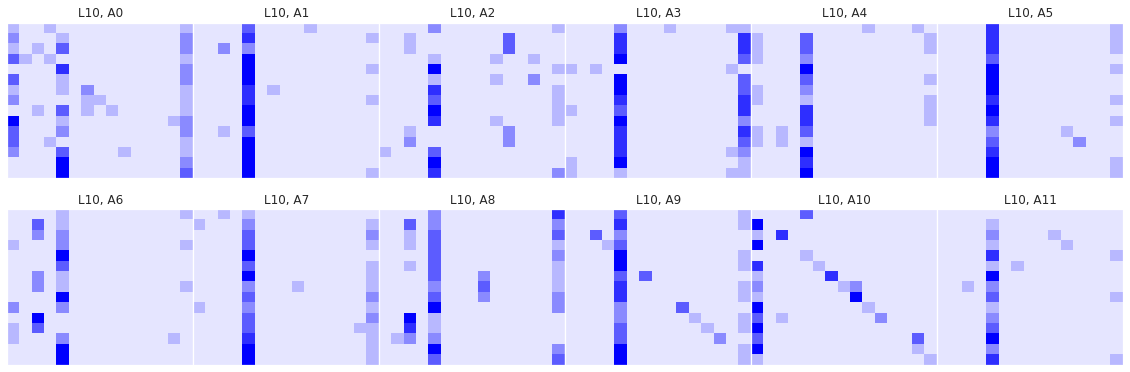

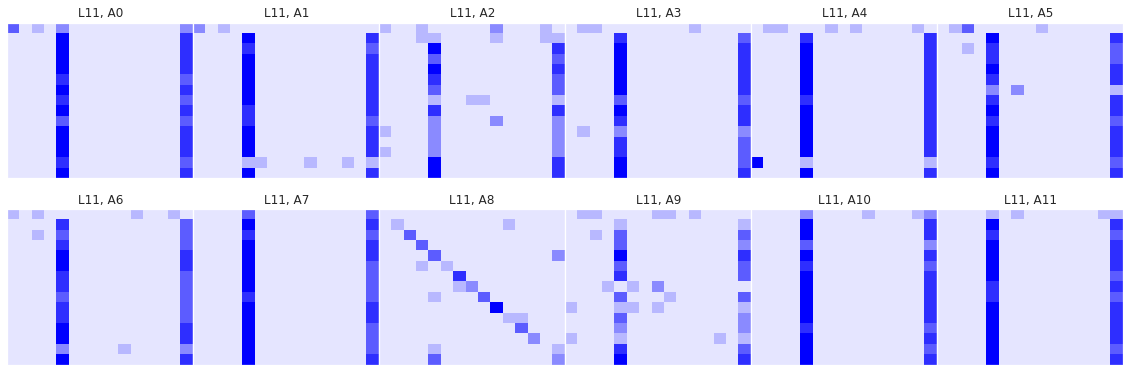

In [56]:
#Plot each attention head inside each layer
for lay in range(0, TOTAL_NO_LAYERS):
  plot_all_attentions(output[2], layer=lay)

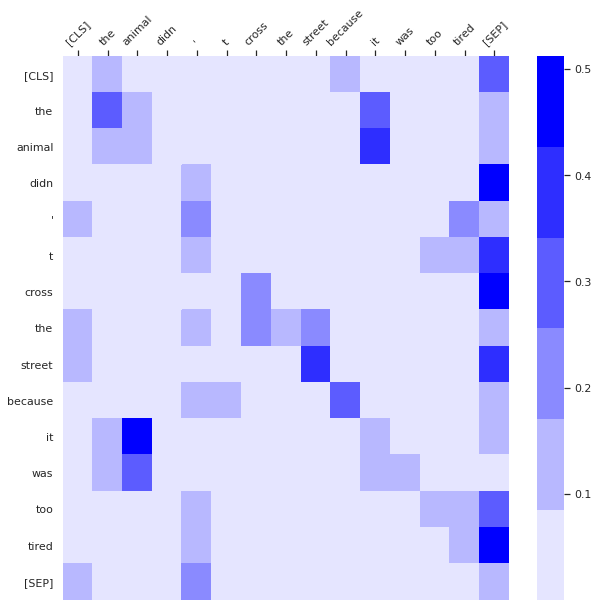

In [57]:
#Let's visualize one of the attention head that seems to have variation in the heatmap
plt_attentions(get_attentions(output[2], layer=9, attention_head=8), tokenized_text)

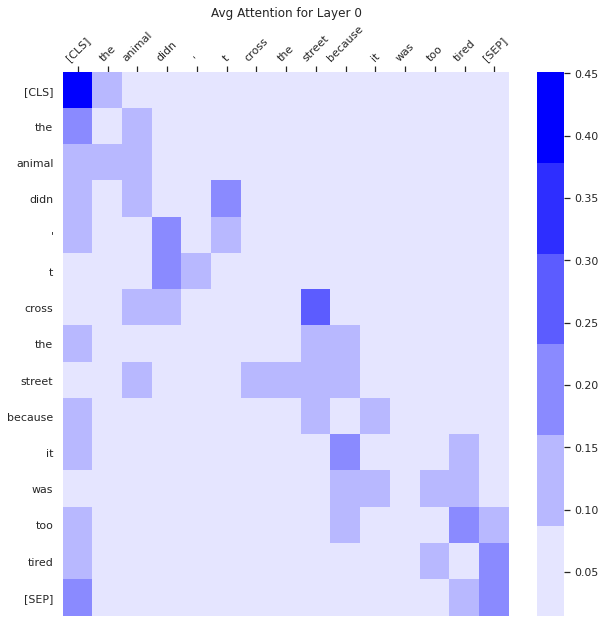

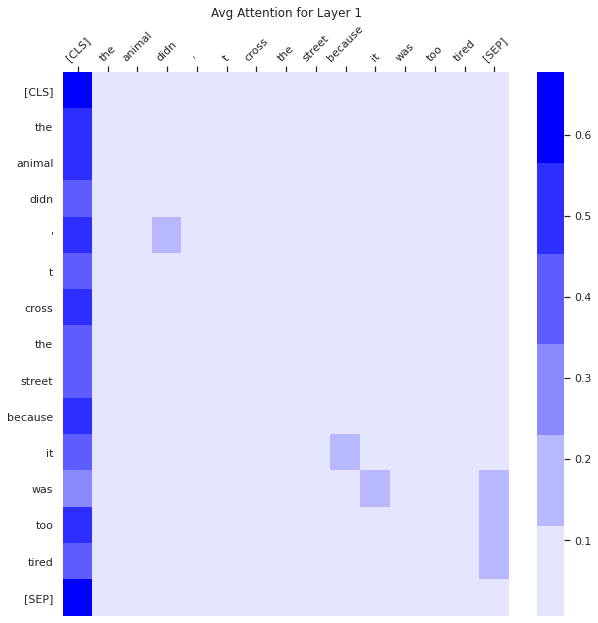

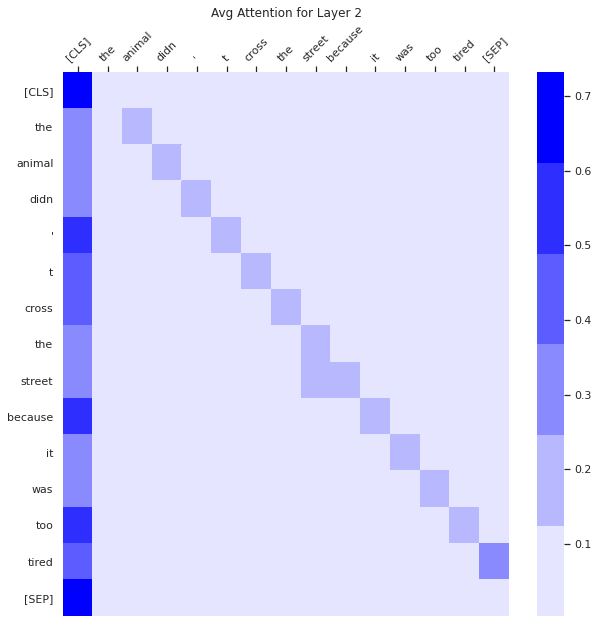

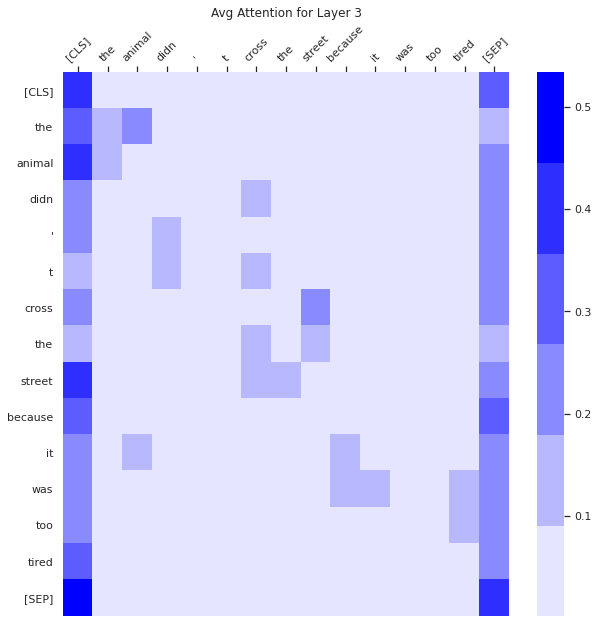

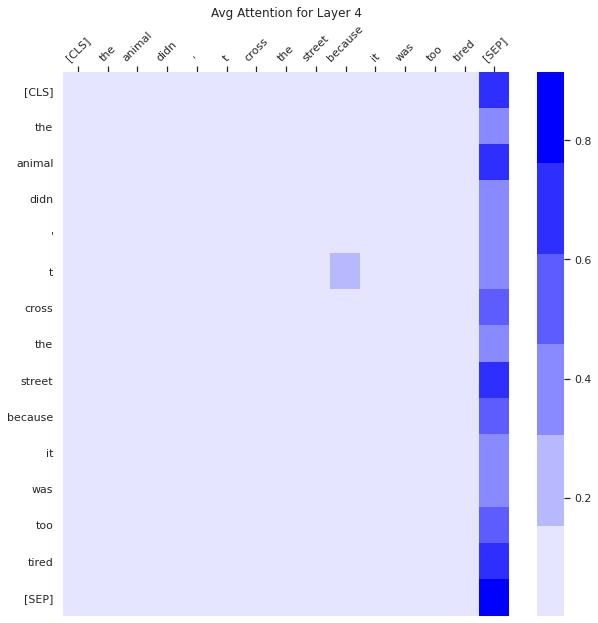

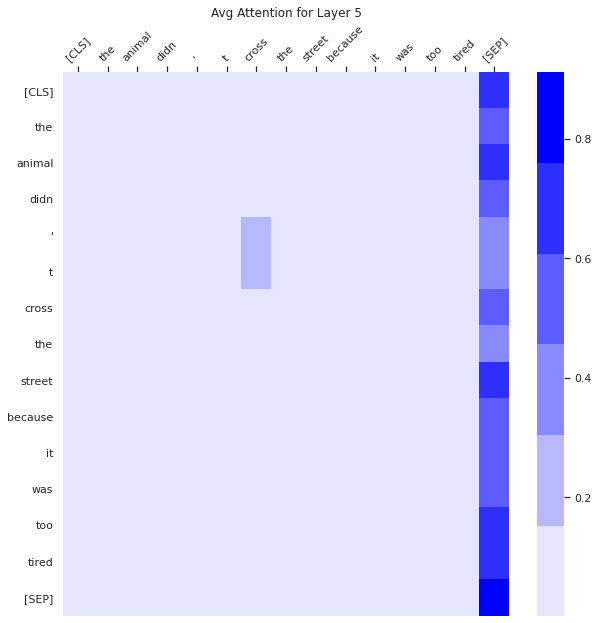

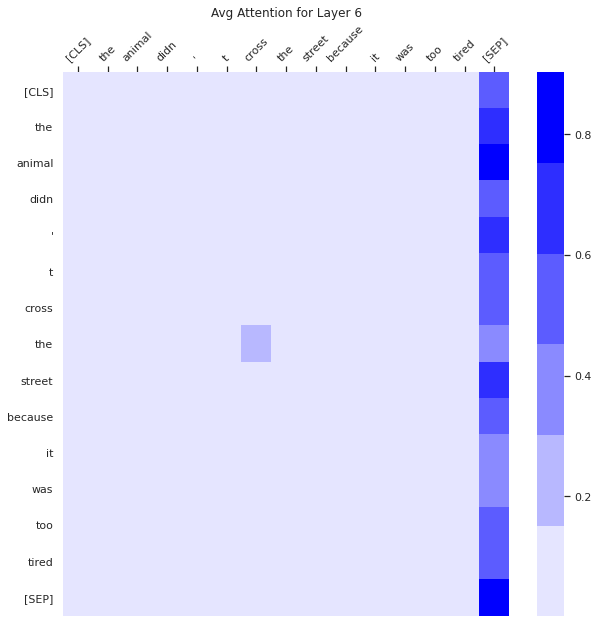

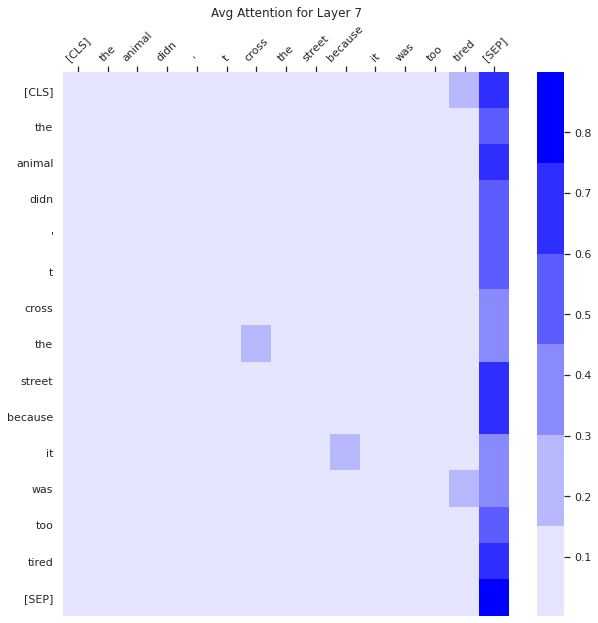

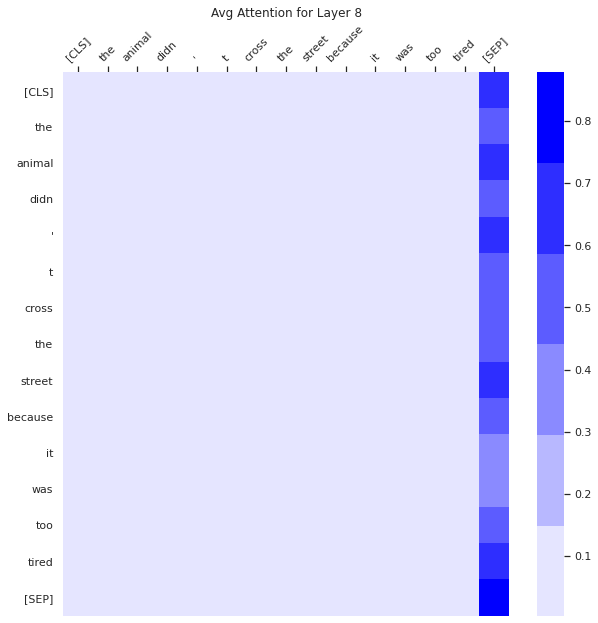

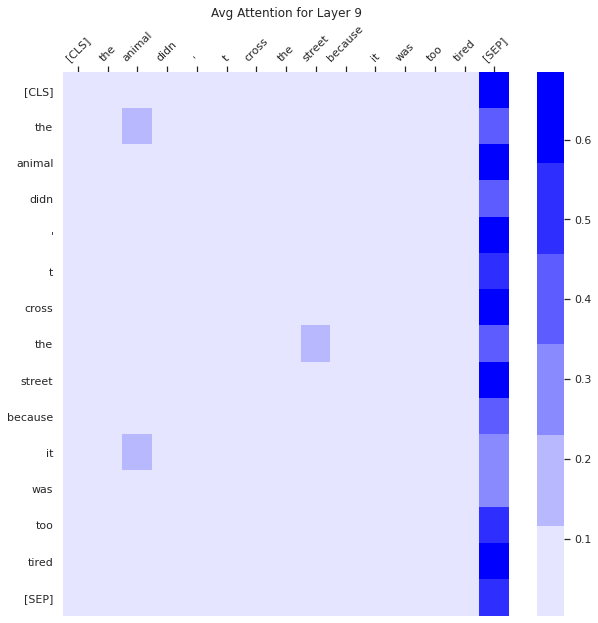

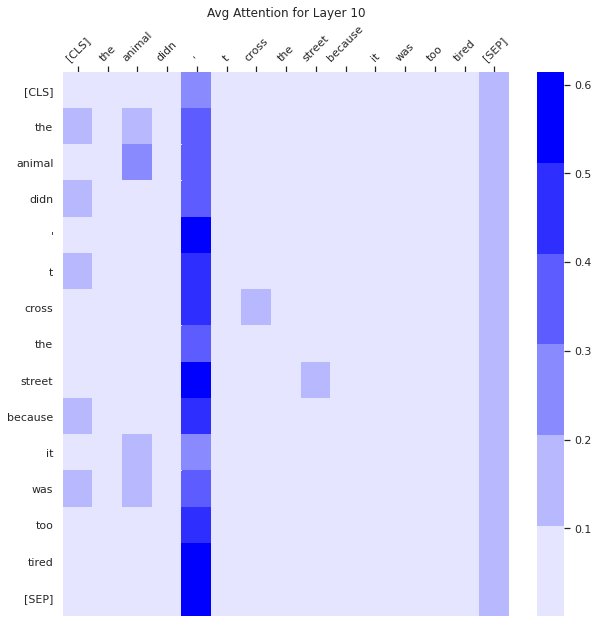

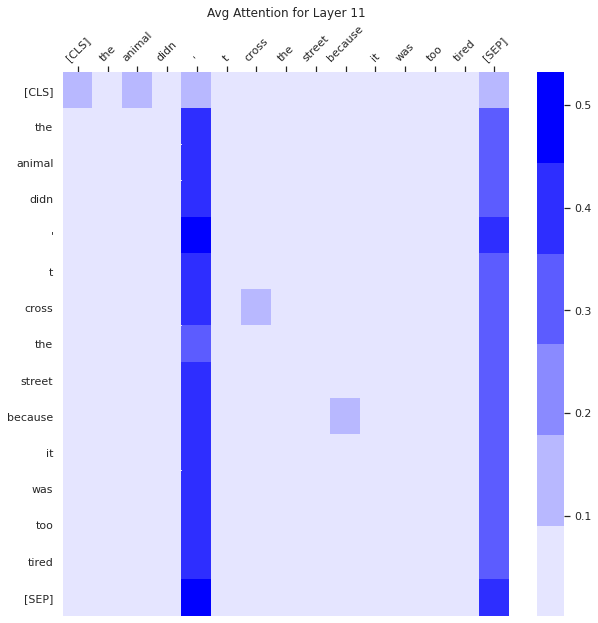

In [58]:
#Plot each attention head inside each layer, averaging all the attentions in that layer
for lay in range(0, TOTAL_NO_LAYERS):
  plt_attentions(get_attentions(output[2], layer=lay, avg=True), tokenized_text, title="Avg Attention for Layer {}".format(lay))